In this experiment, we hope to find a relation between data poisoning and data evasion examples. Even though these two classes of adversarial attacks are completed by different optimization formulations,

Hypothesis: Both add meaningful perturbations in the "unexplored" parts of the data to trick the model into misclassifying examples.

It is well known that adversarial training i.e the inclusion of adversarial examples into the training set acts as a kind of regularizer and improves robustness in defense against data evasion attacks.

To explicitize the relationship between data poisoning and data evasion attacks, we are going to try to examine the effects of crossing these two attacks on the same learning process by testing the following sub-hypotheses:

1. Inclusion of correctly labeled adversarial examples in the training set prior to data poisoning increases the model's performance against poisoning attacks. (Methods that defend against advesarial examples also defend against poisoning)
2. (??) (Methods that defend against poisoning examples also defend against adversarial examples)
3. Inclusion of wrongly labeled adversarial examples in the training set acts as a data poisoning attack. (Adversarial examples function as poisoning examples as well).
4. (??) Poisoning examples function as adversarial examples as well.

The aim is not to create a defense mechanism for one or the other. Instead, we hope to further exploration to gain some more insight into the nature of these two attacks. Because currently in the arms race, the attackers of models are easily winning.. which means that it is probably a good idea to take a break from the battle and gain some more knowledge before we go back out into the bloodshed. 

In [3]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


In [4]:
from cleverhans.utils_tf import model_eval

In [5]:
from cleverhans.attacks import FastGradientMethod
from cleverhans.utils import AccuracyReport

In [15]:
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Dropout, Activation
from keras import regularizers

# Sub-hypothesis 1

### Import the MNIST dataset/ Preprocess the data

In [7]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [8]:
train_images.shape

(60000, 28, 28)

In [9]:
n, img_rows, img_cols = train_images.shape

In [10]:
train_flat = train_images.flatten().reshape(60000, 28*28)
print('Reshape done')
indices = np.random.choice(len(train_flat), 8000)
train_flat_mod = train_flat[indices]
_, sig, _ = np.linalg.svd(train_flat_mod)

Reshape done


In [11]:
train_images = train_images/255.0

test_images = test_images/255.0

In [12]:
train_images = train_images.reshape(n, img_rows, img_cols, 1)
test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

### Phase 1: Create the computation graph

In [12]:
K.image_data_format()

Using TensorFlow backend.


'channels_last'

In [21]:
num_classes = 10

def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(32, (5, 5),
                     activation = 'relu',
                     input_shape = input_shape,
                     #kernel_regularizer=regularizers.l1(0.01)
                    ))
    model.add(keras.layers.Conv2D(32, kernel_size = (3, 3),
                     activation = 'relu', 
                     #kernel_regularizer=regularizers.l1(0.01)
                    ))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', #kernel_regularizer=regularizers.l1(0.01)
                                 ))
    model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu', #kernel_regularizer=regularizers.l1(0.01)
                                 ))
    model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1024, activation = 'relu', #kernel_regularizer=regularizers.l1(0.01)
                                ))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(1024, activation = 'relu', #kernel_regularizer=regularizers.l1(0.005)
                                ))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(num_classes, activation = 'softmax'))
    return model

In [24]:
from keras.layers import Activation
num_classes = 10
def create_model():
    model = keras.Sequential()
    layers = [keras.layers.Conv2D(32, (5,5), input_shape = input_shape),
            keras.layers.Activation('relu'),
            keras.layers.Conv2D(32, kernel_size = (3,3)),
            keras.layers.Activation('relu'),
            keras.layers.MaxPooling2D(pool_size = (2,2)),
            keras.layers.Dropout(0.25),
            keras.layers.Conv2D(64, (3,3)),
            keras.layers.Activation('relu'),
            keras.layers.Conv2D(64, (3,3)),
            keras.layers.Activation('relu'),
            keras.layers.MaxPooling2D(pool_size = (2,2)),
            keras.layers.Dropout(0.25),
            keras.layers.Flatten(),
            keras.layers.Dense(1024),
            keras.layers.Activation('relu'),
            keras.layers.Dense(1024),
            keras.layers.Activation('relu'),
            keras.layers.Dense(num_classes)]
    for layer in layers:
        model.add(layer)
    return model

In [25]:
model = create_model()
model.compile(optimizer = tf.train.AdamOptimizer(),
             loss = 'sparse_categorical_crossentropy',
             metrics =['accuracy'])

In [36]:
x = tf.placeholder(tf.float32, shape = (1,28,28,1))
preds = model(x)

In [15]:
def adv_evaluate(model_input, epsilon_input):
    fgsm = FastGradientMethod(model_input)
    adv_x = fgsm.generate_np(test_images, eps = epsilon_input, clip_min = -2, clip_max = 2)
    preds_adv = model_input.predict(adv_x)
    eval_par = {'batch_size': 60000}
    test_loss, acc = model_input.evaluate(adv_x, test_labels)
    return acc, adv_x, preds_adv

In [16]:
def train_and_test(model_input, X_input, y_input, epochs = 2, eps_test = 0.2):
    model_input.fit(X_input, y_input, epochs = epochs)
    print('finished training')
    test_loss, test_acc = model_input.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    acc, adv_x_np, preds = adv_evaluate(model_input, 0.2)
    print('Test accuracy on adversarial examples:', acc)

### L1 regularization (0.01) on the last layer

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) 
    model.fit(train_images, train_labels, epochs = 2)
    x = train_images[0]
    print(model(x))
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print('Test accuracy:', test_acc)
    acc, adv_x_np, preds = adv_evaluate(model, 0.2)
    print('Test accuracy on adversarial examples:', acc)

Epoch 1/2
   32/60000 [..............................] - ETA: 12:35 - loss: 2.3075 - acc: 0.1250

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x110184f28>>
Traceback (most recent call last):
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


 1728/60000 [..............................] - ETA: 3:33 - loss: 1.6643 - acc: 0.4103

KeyboardInterrupt: 

In [23]:
sess = tf.Session()

In [24]:
sess.run(tf.global_variables_initializer()) 
model.fit(train_images, train_labels, epochs = 2)
x = train_images[0]
print(x.shape) 

Epoch 1/2
60000/60000 [==============================] - 167s 3ms/step - loss: 0.1988 - acc: 0.9366
Epoch 2/2
60000/60000 [==============================] - 170s 3ms/step - loss: 0.0811 - acc: 0.9771
(28, 28, 1)


In [31]:
#x = x.reshape(1, 28, 28, 1)
model.predict(x).shape

(1, 10)

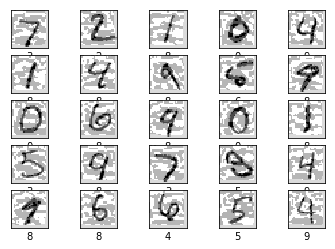

In [28]:
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(adv_x_np[i][:,:,0], cmap = plt.cm.binary)
    plt.xlabel(np.argmax(preds[i]))

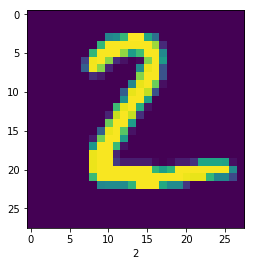

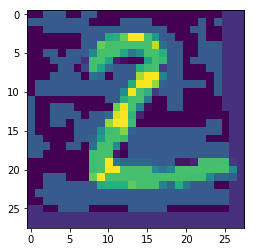

In [30]:
plt.imshow(test_images[1][:,:,0])
plt.xlabel(test_labels[1])
plt.show()
plt.imshow(adv_x_np[1][:,:,0])

### Create train set with 50% added adversarial examples

In [1]:
with tf.Session() as sess:
    #Train the model
    sess.run(tf.global_variables_initializer()) 
    model.fit(train_images, train_labels, epochs = 2)
    x = train_images[0]
    model(x)
    """
    #Choose indices for normal and adversarial examples
    threshold = int(np.round(0.4*n))
    example_indices = range(threshold,n)
    train_indices = range(0, threshold)
    
    #Create the adversarial examples 
    chosen_adv_images = train_images[example_indices]
    fgsm = FastGradientMethod(model, sess = sess)
    adv_x = fgsm.generate_np(chosen_adv_images, eps = 0.5, clip_min = -1, clip_max = 1)

    #Create our new train set
    new_train = np.vstack((train_images[train_indices], adv_x))
    """

NameError: name 'tf' is not defined

In [25]:
with tf.Session() as sess:
    #Train the model
    print('initialized variables')
    sess.run(tf.global_variables_initializer())
    train_and_test(model, train_images, train_labels)
    sess.run(tf.global_variables_initializer())
    layer = model.get_layer(index = 4)
    weights = layer.get_weights()
    train_and_test(model, new_train, train_labels, epochs = 5)

initialized variables
Epoch 1/2
   64/60000 [..............................] - ETA: 9:20 - loss: 2.3049 - acc: 0.1094 

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x18246aca58>>
Traceback (most recent call last):
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


60000/60000 [==============================] - 168s 3ms/step - loss: 0.1977 - acc: 0.9377
Epoch 2/2
60000/60000 [==============================] - 167s 3ms/step - loss: 0.0811 - acc: 0.9766
finished training
  160/10000 [..............................] - ETA: 19s

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x18247d3400>>
Traceback (most recent call last):
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


10000/10000 [==============================] - 8s 803us/step
Test accuracy: 0.987


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x1824e07ef0>>
Traceback (most recent call last):
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1415, in __del__
    self._session._session, self._handle, status)
  File "/Users/adhyyan/miniconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 526, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


10000/10000 [==============================] - 7s 684us/step
Test accuracy on adversarial examples: 0.374
Epoch 1/5
60000/60000 [==============================] - 152s 3ms/step - loss: 0.4905 - acc: 0.8446
Epoch 2/5
60000/60000 [==============================] - 154s 3ms/step - loss: 0.1845 - acc: 0.9487
Epoch 3/5
60000/60000 [==============================] - 158s 3ms/step - loss: 0.1538 - acc: 0.9578
Epoch 4/5
60000/60000 [==============================] - 156s 3ms/step - loss: 0.1357 - acc: 0.9638
Epoch 5/5
60000/60000 [==============================] - 1938s 32ms/step - loss: 0.1298 - acc: 0.9645
finished training
10000/10000 [==============================] - 9s 855us/step
Test accuracy: 0.9841
10000/10000 [==============================] - 9s 950us/step
Test accuracy on adversarial examples: 0.3902


### Aside: Singular value analysis

Reshape done
(784,)


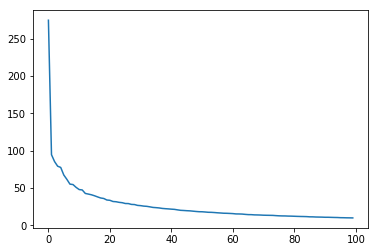

In [29]:
train_flat = train_images.flatten().reshape(train_images.shape[0], 28*28)
print('Reshape done')
indices = np.random.choice(len(train_flat), 2000)
train_flat_mod = train_flat[indices]
_, sig_one, _ = np.linalg.svd(train_flat_mod)

sig_truncated = sig_one[:100]
print(sig.shape)
plt.plot(range(len(sig_truncated)), sig_truncated)

Reshape done
(784,)


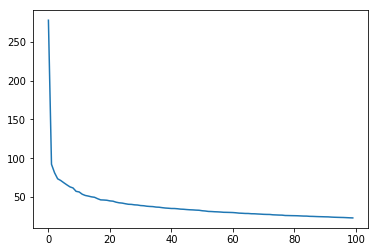

In [30]:
train_flat = new_train.flatten().reshape(new_train.shape[0], 28*28)
print('Reshape done')
indices = np.random.choice(len(train_flat), 2000)
train_flat_mod = train_flat[indices]
_, sig_two, _ = np.linalg.svd(train_flat_mod)

sig_truncated = sig_two[:100]
print(sig.shape)
plt.plot(range(len(sig_truncated)), sig_truncated)

In [46]:
for i in range(0, 40):
    print(str(i) + 'th singular value of original data/new data:   ' + str(sig_one[i]) + '  /   ' + str(sig_two[i]))

0th singular value of original data/new data:   274.59045480410407  /   277.8738605506648
1th singular value of original data/new data:   94.67006879966499  /   92.14404550305478
2th singular value of original data/new data:   85.4641208045191  /   81.21806579785905
3th singular value of original data/new data:   79.29982400544233  /   73.45462232069677
4th singular value of original data/new data:   77.62987149567907  /   71.2663810081689
5th singular value of original data/new data:   67.50687801613289  /   68.38723644490969
6th singular value of original data/new data:   61.69460202436783  /   65.64707335869996
7th singular value of original data/new data:   55.30243872227092  /   63.05702737233417
8th singular value of original data/new data:   54.70964880683631  /   61.645976539010576
9th singular value of original data/new data:   50.97952544581967  /   57.303746832846535
10th singular value of original data/new data:   48.049515544808926  /   56.47299795598209
11th singular valu

If singular values are more concentrated - That means there are lots of "parts" of the data that have low variance and are thus unexplored. Assigning high weights to these parts of the data would be premature because we do not know how the response variable would respond when these "parts" of the data would deviate more from their mean..

According to hypothesis, in the case of adversarial training, the examples would specifically target the unexplored parts of the data that have been assigned high weights to exploit this. Since the "parts" of the data with high singular values have not been changed, the images are still easily classifiable by humans.

The singular value analysis above reveals that:

1. The first few singular values are higher for the original data, but the decay rate is much faster... they are more concentrated.

2. For the adversarially trained data, the decay rate is much slower. If we look at the 100th singular value, the value for the new data is more than twice as much the value for the original data. 

With 0% adversarial examples - 0.21

With 40% adversarial examples - 0.38

With 60% adversarial examples - 0.4273